C:\Users\MYNOTE\AppData\Local\Temp\ipykernel_16660\1513357559.py:109: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\MYNOTE\AppData\Local\Temp\ipykernel_16660\1513357559.py:109: UserWarning: Glyph 53588 (\N{HANGUL SYLLABLE TEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\MYNOTE\AppData\Local\Temp\ipykernel_16660\1513357559.py:109: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\MYNOTE\AppData\Local\Temp\ipykernel_16660\1513357559.py:109: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\MYNOTE\AppData\Local\Temp\ipykernel_16660\1513357559.py:109: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\MYNOTE\App

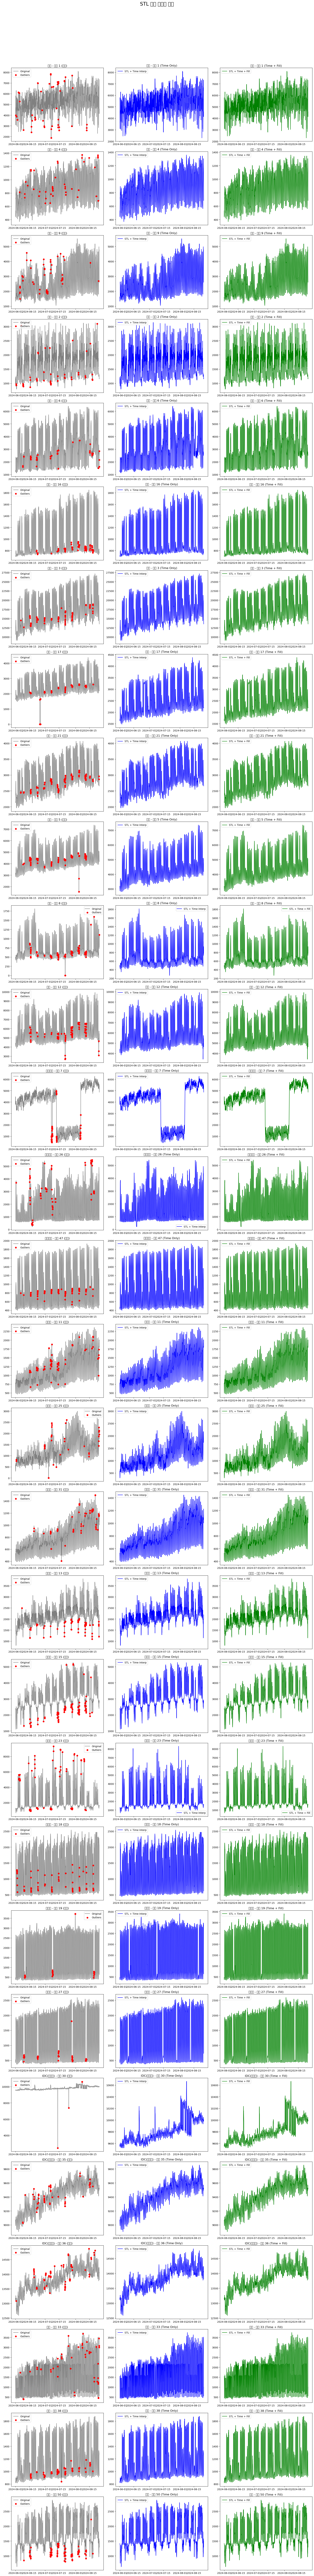

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# 1. 데이터 로드 및 병합
train = pd.read_csv('dataset/train.csv', encoding='utf-8')
bi = pd.read_csv('dataset/building_info.csv', encoding='utf-8')
merged_df = pd.merge(train, bi[['건물번호', '건물유형']], on='건물번호', how='left')
merged_df['전력소비량(kWh)'] = pd.to_numeric(merged_df['전력소비량(kWh)'], errors='coerce')
merged_df['일시'] = pd.to_datetime(merged_df['일시'], format='%Y%m%d %H', errors='coerce')

# 2. 건물유형별 보간
building_types = merged_df['건물유형'].dropna().unique()
all_time_only_dfs = {}
all_time_ffill_dfs = {}

for btype in building_types:
    type_df = merged_df[merged_df['건물유형'] == btype].copy()
    time_only_dfs = []
    time_ffill_dfs = []

    for bid, group in type_df.groupby('건물번호'):
        group = group.sort_values('일시').set_index('일시').asfreq('h')

        # 너무 결측이 많거나 데이터 부족하면 skip
        if group['전력소비량(kWh)'].isna().mean() > 0.2 or len(group) < 48:
            continue

        try:
            # STL 분해로 이상치 탐지
            stl = STL(group['전력소비량(kWh)'], period=24, robust=True)
            result = stl.fit()
            resid = result.resid
            threshold = 3 * resid.std()
            is_outlier = abs(resid) > threshold

            # 이상치 마스킹
            group['보간대상'] = group['전력소비량(kWh)'].copy()
            group.loc[is_outlier, '보간대상'] = np.nan

            # (A) 시간 기반 보간만
            A = group.copy()
            A['보간결과'] = A['보간대상'].interpolate(method='time')
            A = A.reset_index()
            A['건물번호'] = bid
            A['건물유형'] = btype
            time_only_dfs.append(A)

            # (B) 시간 + ffill + bfill
            B = group.copy()
            B['보간결과'] = B['보간대상'].interpolate(method='time').ffill().bfill()
            B = B.reset_index()
            B['건물번호'] = bid
            B['건물유형'] = btype
            time_ffill_dfs.append(B)

        except Exception:
            continue

    all_time_only_dfs[btype] = time_only_dfs
    all_time_ffill_dfs[btype] = time_ffill_dfs

# 3. 시각화 (각 건물유형당 최대 3개 건물)
fig_rows = sum(len(dfs[:3]) for dfs in all_time_only_dfs.values())
fig, axes = plt.subplots(fig_rows, 3, figsize=(18, 5 * fig_rows))
fig.suptitle("STL 기반 보간법 비교", fontsize=20)

row = 0
for btype in building_types:
    original_df = merged_df[merged_df['건물유형'] == btype]
    sample_dfs = all_time_only_dfs[btype][:3]
    sample_ffill_dfs = all_time_ffill_dfs[btype][:3]

    for i in range(len(sample_dfs)):
        bid = sample_dfs[i]['건물번호'].iloc[0]

        original = original_df[original_df['건물번호'] == bid].sort_values('일시')
        time_only = sample_dfs[i].sort_values('일시')
        time_ffill = sample_ffill_dfs[i].sort_values('일시')

        # STL 이상치 기준 마스킹
        original_stl = original.set_index('일시').asfreq('h')
        stl = STL(original_stl['전력소비량(kWh)'], period=24, robust=True).fit()
        resid = stl.resid
        threshold = 3 * resid.std()
        is_outlier = abs(resid) > threshold
        outlier_times = resid.index[is_outlier]

        # 시각화 - 이상치 scatter 시 안전하게
        axes[row, 0].plot(original['일시'], original['전력소비량(kWh)'], label='Original', color='gray')
        axes[row, 0].scatter(outlier_times, original_stl.loc[outlier_times, '전력소비량(kWh)'],
                     color='red', label='Outliers', zorder=3)
        axes[row, 0].set_title(f"{btype} - 건물 {bid} (원본)")
        axes[row, 0].legend()

        # 2. 시간 기반 보간
        axes[row, 1].plot(time_only['일시'], time_only['보간결과'], color='blue', label='STL + Time Interp')
        axes[row, 1].set_title(f"{btype} - 건물 {bid} (Time Only)")
        axes[row, 1].legend()

        # 3. 시간 + ffill + bfill
        axes[row, 2].plot(time_ffill['일시'], time_ffill['보간결과'], color='green', label='STL + Time + Fill')
        axes[row, 2].set_title(f"{btype} - 건물 {bid} (Time + Fill)")
        axes[row, 2].legend()

        row += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
